In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [7]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [4]:
uk = df[df.Country == 'United Kingdom'].reset_index(drop=True)
uk.InvoiceDate = pd.to_datetime(uk.InvoiceDate)
uk['Revenue'] = uk.UnitPrice * uk.Quantity

In [12]:
#Segmentation
uk_3m = uk[(uk.InvoiceDate < '2011-6-1') & (uk.InvoiceDate >= '2011-3-1')].reset_index(drop=True)
uk_6m = uk[(uk.InvoiceDate >= '2011-6-1') & (uk.InvoiceDate < '2011-12-1')].reset_index(drop=True)

uk_user = pd.DataFrame(uk_3m['CustomerID'].unique(), columns=['CustomerID'])

def order_cluster(cluster_field_name, target_field_name, df, ascending=False):
    df_idx = df.groupby(cluster_field_name)[target_field_name].mean().sort_values(ascending=ascending).reset_index()
    df_idx['index'] = df_idx.index
    df_last = pd.merge(df, df_idx[[cluster_field_name,'index']], on=cluster_field_name)
    df_last = df_last.drop([cluster_field_name], axis=1)
    df_last = df_last.rename(columns={'index':cluster_field_name})
    return df_last

#MaxPurchaseDate
uk_max_purchase = uk_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

uk_max_purchase['Recency'] = (uk_max_purchase.MaxPurchaseDate.max() - uk_max_purchase.MaxPurchaseDate).dt.days

uk_user = pd.merge(uk_user, uk_max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4).fit(uk_user[['Recency']])
uk_user['RecencyCluster'] = kmeans.predict(uk_user[['Recency']])
uk_user = order_cluster('RecencyCluster', 'Recency', uk_user)

#Frequency
uk_frequency = uk_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
uk_frequency.columns = ['CustomerID','Frequency']

uk_user = pd.merge(uk_user, uk_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4).fit(uk_user[['Frequency']])
uk_user['FrequencyCluster'] = kmeans.predict(uk_user[['Frequency']])
uk_user = order_cluster('FrequencyCluster', 'Frequency', uk_user, True)

#Revenue
uk_revenue = uk_3m.groupby('CustomerID').Revenue.sum().reset_index()
uk_revenue.columns = ['CustomerID','Revenue']

uk_user = pd.merge(uk_user, uk_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4).fit(uk_user[['Revenue']])
uk_user['RevenueCluster'] = kmeans.predict(uk_user[['Revenue']])
uk_user = order_cluster('RevenueCluster', 'Revenue', uk_user, True)

#Overall
uk_user['OverallScore'] = uk_user['RecencyCluster'] + uk_user['FrequencyCluster'] + uk_user['RevenueCluster']
uk_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

uk_user['Segment'] = 'Low-Value'
uk_user.loc[uk_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
uk_user.loc[uk_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [13]:
uk_user.head(3)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value


In [10]:
uk_user_6m = uk_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
uk_user_6m.columns = ['CustomerID','m6_Revenue']

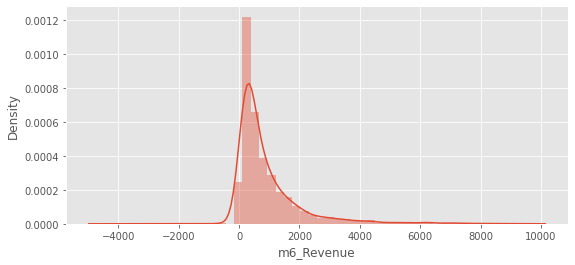

In [11]:
plt.figure(figsize=(9,4))
sns.distplot(uk_user_6m.m6_Revenue[uk_user_6m.m6_Revenue < 10000]);

In [14]:
uk_merge = pd.merge(uk_user, uk_user_6m, on='CustomerID', how='left')
uk_merge = uk_merge.fillna(0)

In [15]:
uk_merge.head(3)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54


In [16]:
uk_graph = uk_merge[(uk_merge.m6_Revenue < 30000)]

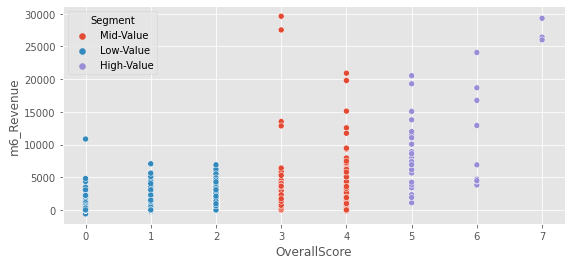

In [17]:
plt.figure(figsize=(9,4))
sns.scatterplot(x='OverallScore', y='m6_Revenue', hue='Segment', data=uk_graph);

In [19]:
uk_merge[['m6_Revenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
m6_Revenue,1840.0,1477.073865,6039.528767,-609.4,0.0,515.085,1375.695,180469.05


In [20]:
uk_merge.m6_Revenue.quantile(0.99)

17929.15699999989

In [21]:
uk_merge = uk_merge[uk_merge['m6_Revenue']<uk_merge['m6_Revenue'].quantile(0.99)]

In [22]:
kmeans = KMeans(n_clusters=3).fit(uk_merge[['m6_Revenue']])
uk_merge['LTVCluster'] = kmeans.predict(uk_merge[['m6_Revenue']])

uk_merge = order_cluster('LTVCluster', 'm6_Revenue', uk_merge, True)

uk_cluster = uk_merge.copy()

In [23]:
uk_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [26]:
uk_class = pd.get_dummies(uk_cluster)

In [27]:
uk_class.head(3)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1


In [28]:
uk_class.corr()['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.463930
OverallScore          0.373231
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.353218
RecencyCluster        0.236899
Segment_Mid-Value     0.166854
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: LTVCluster, dtype: float64

In [31]:
y = uk_class['LTVCluster']
X = uk_class.drop(['LTVCluster','m6_Revenue'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective= 'multi:softprob', n_jobs=-1).fit(x_train, y_train)

print('Accuracy of XGB classifier on training set: {:.3f}'.format(ltv_xgb_model.score(x_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.3f}'.format(ltv_xgb_model.score(x_test[x_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(x_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.929
Accuracy of XGB classifier on test set: 0.797
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       285
           1       0.47      0.40      0.43        70
           2       0.60      0.60      0.60        10

    accuracy                           0.80       365
   macro avg       0.65      0.63      0.64       365
weighted avg       0.79      0.80      0.79       365

